# N-Gram Next Word Prediction Model

We seek to create a model that, given a string of text, can reliably predict the following *n* words. The model will be a probabilistic N-Gram model. This should mainly serve as a lightweight test that will not perform amazingly besides the first couple of words.

## Preprocessing

In [1]:
import sys
sys.path.append('../')
from util.process import Process
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
FILE_NAME = 'sherlock_holmes_text.txt'

sentences = Process.file_to_sentences(FILE_NAME)

In [3]:
sentences=sentences[4:]
sentences = [Process.modify_tokens(word_tokenize(sentence)) for sentence in sentences]

In [ ]:
sentences[0:10]

### Creating the n-grams

In [5]:
def create_ngrams(sentences: list, n=3) -> list:
    ngrams = []
    for sentence in sentences:
        for i in range(len(sentence)-n+1):
            ngrams.append(sentence[i:i+n])
    return ngrams

In [6]:
ngrams = create_ngrams(sentences)

ngrams[:10]

[['I', 'have', 'seldom'],
 ['have', 'seldom', 'heard'],
 ['seldom', 'heard', 'him'],
 ['heard', 'him', 'mention'],
 ['him', 'mention', 'her'],
 ['mention', 'her', 'under'],
 ['her', 'under', 'any'],
 ['under', 'any', 'other'],
 ['any', 'other', 'name.'],
 ['In', 'his', 'eyes']]

## Model Prototype

In [7]:
# Now we can create the model
from collections import defaultdict

In [8]:
model = defaultdict(lambda: defaultdict(int))

for ngram in ngrams:
    w1, w2, w3 = ngram
    model[(w1, w2)][w3] += 1

### Data Viz

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [10]:

def plot_model(model: dict, w1: str, w2: str, top_n=10):
    words = [w for w, _ in sorted(model[(w1, w2)].items(), key=lambda x: x[1], reverse=True)[:top_n]]
    counts = [c for _, c in sorted(model[(w1, w2)].items(), key=lambda x: x[1], reverse=True)[:top_n]]
    colors = cm.rainbow(np.linspace(0, 1, len(words)))
    plt.bar(words, counts, color=colors)
    plt.xticks(rotation=45)
    plt.show()

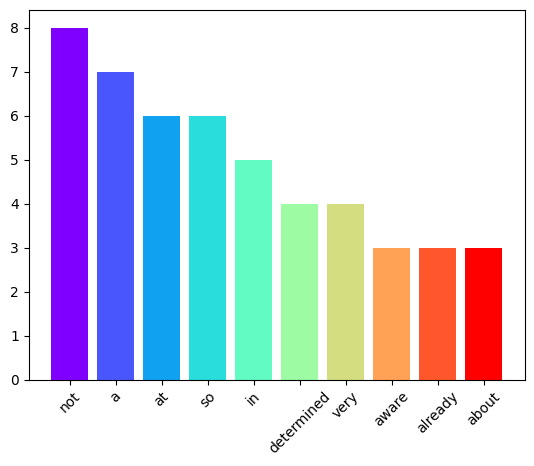

In [11]:
plot_model(model, 'I', 'was')

## Prototype Testing

In [19]:
def generate_next_n_words(model: dict, w1: str, w2: str, n=10) -> list:
    words = []
    for i in range(n):
        if not model[(w1, w2)]:
            break
        w3 = max(model[(w1, w2)], key=model[(w1, w2)].get)
        words.append(w3)
        w1, w2 = w2, w3
    return words

In [20]:
generate_next_n_words(model, 'I', 'was', 20)

['not',
 'a',
 'very',
 'serious',
 'one',
 'to',
 'the',
 'other',
 'hand,',
 'he',
 'had',
 'been',
 'in',
 'the',
 'morning.']

In [21]:
generate_next_n_words(model, 'Sherlock', 'Holmes', 20)

['was',
 'not',
 'a',
 'very',
 'serious',
 'one',
 'to',
 'the',
 'other',
 'hand,',
 'he',
 'had',
 'been',
 'in',
 'the',
 'morning.']

The n-gram model generates some comprehensible text, but quickly loses meaning past the first couple of words. It seems to really lack any kind of memory, as we see it go in loops and generate similar text for different prompts. This may be a consequence of our choice to use trigrams rather than larger assortments.

## Improving the Model

In [68]:
larger_model = defaultdict(lambda: defaultdict(int))

fourgrams = create_ngrams(sentences, n=4)
trigrams = create_ngrams(sentences, n=3)
bigrams = create_ngrams(sentences, n=2)

In [69]:
fourgrams[:10]

[['I', 'have', 'seldom', 'heard'],
 ['have', 'seldom', 'heard', 'him'],
 ['seldom', 'heard', 'him', 'mention'],
 ['heard', 'him', 'mention', 'her'],
 ['him', 'mention', 'her', 'under'],
 ['mention', 'her', 'under', 'any'],
 ['her', 'under', 'any', 'other'],
 ['under', 'any', 'other', 'name.'],
 ['In', 'his', 'eyes', 'she'],
 ['his', 'eyes', 'she', 'eclipses']]

In [70]:
len(trigrams)

91709

In [74]:
ngrams = fourgrams + trigrams + bigrams

for ngram in ngrams:
    if len(ngram) == 4:
        w1, w2, w3, w4 = ngram
        larger_model[(w1, w2, w3)][w4] += 1
    elif len(ngram) == 3:
        w1, w2, w3 = ngram
        larger_model[(w1, w2)][w3] += 1
    elif len(ngram) == 2:
        w1, w2 = ngram
        larger_model[(w1)][w2] += 1

In [75]:
larger_model

defaultdict(<function __main__.<lambda>()>,
            {('I',
              'have',
              'seldom'): defaultdict(int, {'heard': 1, 'seen': 1}),
             ('have', 'seldom', 'heard'): defaultdict(int, {'him': 1}),
             ('seldom', 'heard', 'him'): defaultdict(int, {'mention': 1}),
             ('heard', 'him', 'mention'): defaultdict(int, {'her': 1}),
             ('him', 'mention', 'her'): defaultdict(int, {'under': 1}),
             ('mention', 'her', 'under'): defaultdict(int, {'any': 1}),
             ('her', 'under', 'any'): defaultdict(int, {'other': 1}),
             ('under', 'any', 'other'): defaultdict(int, {'name.': 1}),
             ('In', 'his', 'eyes'): defaultdict(int, {'she': 1}),
             ('his', 'eyes', 'she'): defaultdict(int, {'eclipses': 1}),
             ('eyes', 'she', 'eclipses'): defaultdict(int, {'and': 1}),
             ('she', 'eclipses', 'and'): defaultdict(int, {'predominates': 1}),
             ('eclipses', 'and', 'predominates'): de

## Testing the Final Model

In [76]:
def generate_next_n_words(model: dict, input: str, n=10) -> list:
    words = input.split()
    for i in range(n):
        if not model[tuple(words[-4:])]:
            if not model[tuple(words[-3:])]:
                if not model[tuple(words[-2:])]:
                    if not model[tuple(words[-1:])]:
                        break
                    w = max(model[tuple(words[-1:])], key=model[tuple(words[-1:])].get)
                    words.append(w)
                else:
                    w = max(model[tuple(words[-2:])], key=model[tuple(words[-2:])].get)
                    words.append(w)
            else:
                w = max(model[tuple(words[-3:])], key=model[tuple(words[-3:])].get)
                words.append(w)
        else:
            w = max(model[tuple(words[-4:])], key=model[tuple(words[-4:])].get)
            words.append(w)
    return ' '.join(words)

In [ ]:
model[('Sherlock', 'Holmes')]

In [79]:
generate_next_n_words(larger_model, 'I was', 20)

'I was not to have the vacancy after all; but after thinking it over for a few minutes of his seeingMr. McCarthy'

In [80]:
generate_next_n_words(larger_model, 'Sherlock Holmes', 20)

'Sherlock Holmes was not very communicative during the long drive and lay back in the cab humming the tunes which he had'

In [83]:
generate_next_n_words(larger_model, 'His name is', 20)

'His name is Vincent Spaulding, and hes not such a youth, either.'

In [82]:
generate_next_n_words(larger_model, 'His name was ', 20)

'His name was new to him.'

The model is certainly performing much better! Although in some cases, the model is directly ripping text off from the book, it is also sometimes generating original sentences that are comprehensible. We will probably have better luck with a LSTM architecture.